<a href="https://colab.research.google.com/github/kamilenovaes/machine-learning-python/blob/main/notebooks/01_Simple_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressão Linear Simples

## 🎯 Objetivos

- Usar o **scikit-learn** para implementar **regressão linear simples**
- Criar, treinar e testar um modelo de regressão linear com dados reais

> **Ideia central:** aprender a ajustar uma reta para prever uma variável (ex.: emissão de CO₂) a partir de **uma** característica (ex.: tamanho do motor).

### 1. Importar bibliotecas


- **NumPy** (operações numéricas e vetores)
- **Matplotlib** (visualização)
- **Pandas** (carregamento e manipulação do dataset)
- **Scikit-learn** (modelo de regressão linear, treino/teste e métricas)

> Aqui o foco é **o porquê** de cada etapa no pipeline de ML: carregar → explorar → escolher variáveis → separar treino/teste → treinar → avaliar.

In [ ]:
# necessário para outros ambientes fora colab
# !pip install numpy==2.2.0
# !pip install pandas==2.2.3
# !pip install scikit-learn==1.6.0
# !pip install matplotlib==3.9.3

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## 2. Carregar Dados


In [ ]:
url= "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%202/data/FuelConsumptionCo2.csv"

In [ ]:
df=pd.read_csv(url)

In [ ]:
# Verificando se o carregamento funcionou (amostra aleatória)
df.sample(5)

,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
674,2014,LEXUS,RX 350 AWD,SUV - SMALL,3.5,6,AS6,X,13.3,9.8,11.7,24,269
913,2014,RAM,1500 4X4 DIESEL,PICKUP TRUCK - STANDARD,3.0,6,A8,D,12.1,8.8,10.6,27,286
188,2014,CHEVROLET,CAMARO,COMPACT,3.6,6,AS6,X,13.2,8.7,11.2,25,258
460,2014,GMC,SIERRA 4WD,PICKUP TRUCK - STANDARD,5.3,8,A6,X,14.9,10.6,13.0,22,299
1029,2014,VOLKSWAGEN,EOS,SUBCOMPACT,2.0,4,A6,Z,10.9,8.0,9.6,29,221


## 3. Entender o dataset

O arquivo usado aqui é um dataset de consumo de combustível e emissões de carros (do governo do Canadá).  
Fonte: [Open Canada](http://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64).

Principais colunas:

- **MODELYEAR**: ano do modelo (ex.: 2014)
- **MAKE**: fabricante (ex.: VOLVO)
- **MODEL**: modelo (ex.: S60 AWD)
- **VEHICLECLASS**: classe do veículo (ex.: COMPACT)
- **ENGINESIZE**: tamanho do motor em litros (ex.: 3.0)
- **CYLINDERS**: número de cilindros (ex.: 6)
- **FUELCONSUMPTION_CITY**: consumo na cidade (L/100 km)
- **FUELCONSUMPTION_HWY**: consumo na estrada (L/100 km)
- **FUELCONSUMPTION_COMB**: consumo combinado (L/100 km)
- **FUELCONSUMPTION_COMB_MPG**: consumo combinado (MPG)
- **CO2EMISSIONS**: emissões de CO₂ (g/km)

**Tarefa:** construir um modelo de **regressão linear simples** usando **uma** dessas features para prever **CO2EMISSIONS** de carros não observados (novos exemplos).

### 3.1. Explorar estatísticas descritivas


In [ ]:
df.describe()

,MODELYEAR,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
count,1067.0,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000
mean,2014.0,3.346298,5.794752,13.296532,9.474602,11.580881,26.441425,256.228679
std,0.0,1.415895,1.797447,4.101253,2.794510,3.485595,7.468702,63.372304
min,2014.0,1.000000,3.000000,4.600000,4.900000,4.700000,11.000000,108.000000
25%,2014.0,2.000000,4.000000,10.250000,7.500000,9.000000,21.000000,207.000000
50%,2014.0,3.400000,6.000000,12.600000,8.800000,10.900000,26.000000,251.000000
75%,2014.0,4.300000,8.000000,15.550000,10.850000,13.350000,31.000000,294.000000
max,2014.0,8.400000,12.000000,30.200000,20.500000,25.800000,60.000000,488.000000


Pelo `describe()`, dá para ver que a maioria dos carros (cerca de 75%) tem eficiência entre ~11 e ~31 MPG.  
Se existir um valor muito alto (ex.: 60 MPG), ele pode ser:

- um carro extremamente eficiente (híbrido/compacto), **ou**
- um **outlier** / erro de medição ou de digitação.

Se uma coluna tiver **desvio padrão ~0** (como `MODELYEAR` neste dataset), ela não varia e portanto não traz informação útil para prever outra variável (não ajuda um modelo a “aprender”).

#### 3.2. Selecionar algumas features
Vamos selecionar algumas variáveis que *podem* estar relacionadas com emissões de CO₂, para inspecionar melhor.

In [ ]:
cdf = df[['ENGINESIZE','CYLINDERS','FUELCONSUMPTION_COMB','CO2EMISSIONS']]
cdf.sample(9)

,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_COMB,CO2EMISSIONS
251,1.4,4,8.0,184
248,1.4,4,7.5,173
388,5.0,8,20.0,320
602,1.8,4,8.0,184
637,3.0,6,14.5,334
95,3.0,6,10.0,230
5,3.5,6,10.0,230
442,5.3,8,22.6,362
556,5.0,8,13.3,306


#### 3.3. Visualizar distribuições e relações


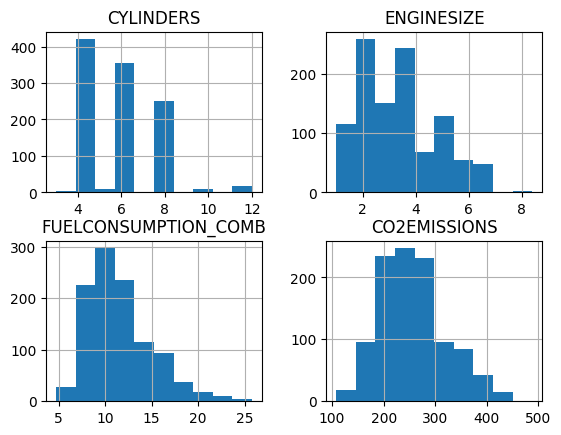

In [ ]:
viz = cdf[['CYLINDERS','ENGINESIZE','FUELCONSUMPTION_COMB','CO2EMISSIONS']]
viz.hist()
plt.show()

Observações deste dataset:

- A maior parte dos motores tem **4, 6 ou 8 cilindros**, e tamanho do motor entre **~2 e 4 litros**.
- `FUELCONSUMPTION_COMB` e `CO2EMISSIONS` tendem a ter distribuições parecidas (quanto maior o consumo, maior a emissão).

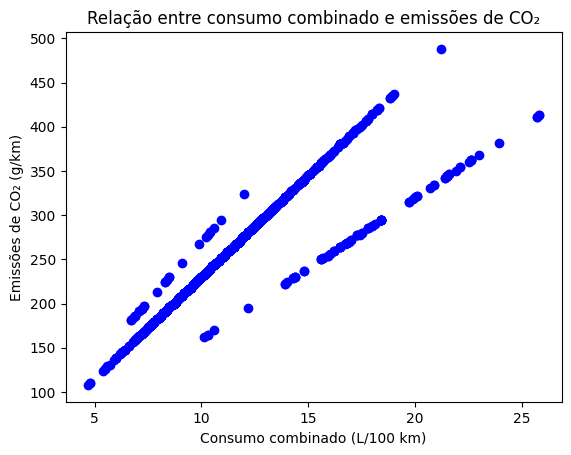

In [ ]:
plt.scatter(cdf.FUELCONSUMPTION_COMB, cdf.CO2EMISSIONS, color='blue')
plt.xlabel("Consumo combinado (L/100 km)")
plt.ylabel("Emissões de CO₂ (g/km)")
plt.title("Relação entre consumo combinado e emissões de CO₂")
plt.show()

Ao plotar `FUELCONSUMPTION_COMB` vs `CO2EMISSIONS`, é comum aparecerem faixas/grupos de carros com relações lineares fortes.  
O intercepto (ponto onde a reta cruza o eixo y) pode ser parecido entre grupos, mas as inclinações mudam. Isso sugere que outras variáveis (ex.: tipo de veículo, transmissão etc.) também influenciam.

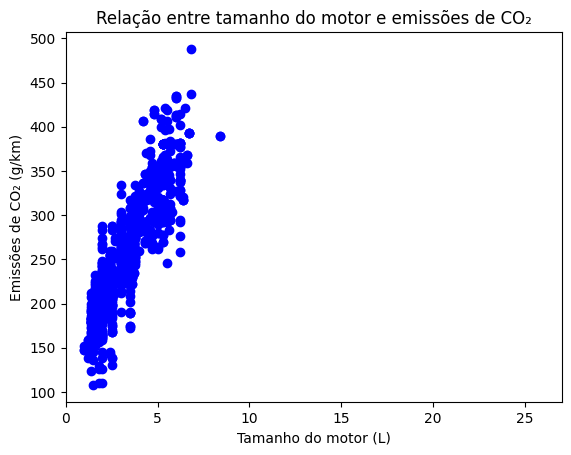

In [ ]:
plt.scatter(cdf.ENGINESIZE, cdf.CO2EMISSIONS, color='blue')
plt.xlabel("Tamanho do motor (L)")
plt.ylabel("Emissões de CO₂ (g/km)")
plt.title("Relação entre tamanho do motor e emissões de CO₂")
plt.xlim(0,27)
plt.show()

Quando comparamos `ENGINESIZE` vs `CO2EMISSIONS`, a tendência ainda existe, mas pode ser **mais fraca** do que a observada com consumo combinado.  
Neste gráfico o range do eixo x costuma ser ajustado para facilitar a comparação visual.

#### Exercício [1]
Plote **CYLINDERS** vs **CO2EMISSIONS** e avalie visualmente quão linear parece a relação.

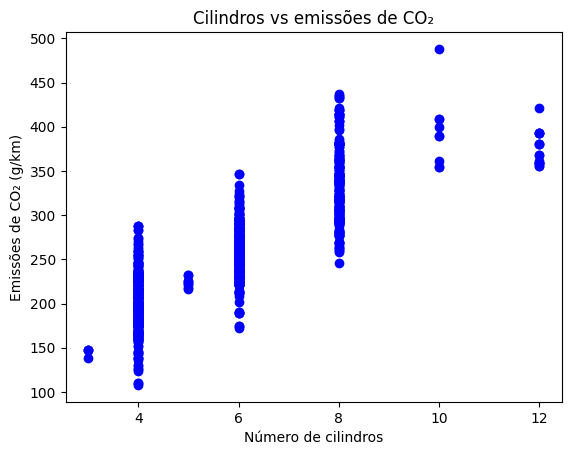

In [ ]:
plt.scatter(cdf.CYLINDERS, cdf.CO2EMISSIONS, color='blue')
plt.xlabel("Número de cilindros")
plt.ylabel("Emissões de CO₂ (g/km)")
plt.title("Cilindros vs emissões de CO₂")
plt.show()

## 4. Preparar dados para o modelo (feature e alvo)

Para fins didáticos, vamos usar **ENGINESIZE** como feature (entrada) e prever **CO2EMISSIONS** (saída/label).  
Talvez não seja a melhor feature possível, mas serve para ilustrar o processo de regressão linear simples.

- **X**: feature (uma variável)
- **y**: alvo (o que queremos prever)

In [ ]:
X = cdf.ENGINESIZE.to_numpy()
y = cdf.CO2EMISSIONS.to_numpy()

### 4.1. Separar em treino e teste


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

As saídas do `train_test_split` são vetores (arrays 1D) do NumPy.


In [ ]:
type(X_train), np.shape(X_train), np.shape(X_train)

(numpy.ndarray, (853,), (853,))

## 5) Treinar um modelo de regressão linear simples

Vamos usar `LinearRegression` do **scikit-learn** para ajustar uma reta aos dados de treino.  
Documentação: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [ ]:
from sklearn import linear_model

# 1) Criar o objeto do modelo
regressor = linear_model.LinearRegression()

# 2) Treinar (ajustar) o modelo nos dados de treino
# Observação importante:
# - X_train aqui é um vetor 1D (shape = [n_amostras])
# - mas o scikit-learn espera uma matriz 2D (shape = [n_amostras, n_features])
# Como estamos usando apenas 1 feature, fazemos reshape para virar [n_amostras, 1].
regressor.fit(X_train.reshape(-1, 1), y_train)

# 3) Ver parâmetros aprendidos
# Em regressão linear simples, existe apenas 1 coeficiente (b1).
print("Coeficiente (b1):", regressor.coef_[0])
print("Intercepto (b0):", regressor.intercept_)

Coeficiente (b1): 38.992978724434074
Intercepto (b0): 126.28970217408721


Aqui:

- **Coeficiente** (b1) define a inclinação da reta (quanto o y muda quando x aumenta 1 unidade).
- **Intercepto** (b0) é o valor de y quando x = 0.

Esses parâmetros são escolhidos para minimizar o erro no treino (em geral, via mínimos quadrados).

### 5.1. Visualizar a reta ajustada


O modelo ajustado é uma reta do tipo:  `y = b0 + b1 · x`.


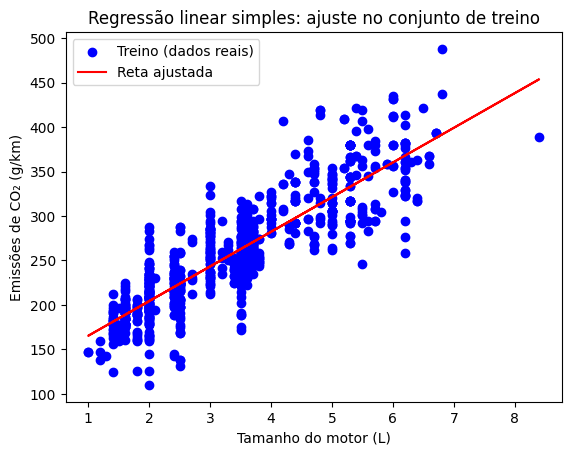

In [ ]:
plt.scatter(X_train, y_train, color='blue', label="Treino (dados reais)")
plt.plot(X_train, regressor.coef_[0]*X_train + regressor.intercept_, '-r', label="Reta ajustada")
plt.xlabel("Tamanho do motor (L)")
plt.ylabel("Emissões de CO₂ (g/km)")
plt.title("Regressão linear simples: ajuste no conjunto de treino")
plt.legend()
plt.show()

## 6. Avaliar o modelo

Há várias métricas para avaliar regressão. Aqui usamos principalmente **MSE** no conjunto de **teste** (dados que o modelo não viu no treino).

- **MAE (Mean Absolute Error)**: média dos valores absolutos dos erros.
- **MSE (Mean Squared Error)**: média do erro ao quadrado. Penaliza mais erros grandes; é a métrica ligada ao ajuste por mínimos quadrados.
- **RMSE (Root MSE)**: Volta para a mesma unidade do alvo (g/km), então costuma ser mais interpretável.
- **R² (R2-Score)**: mede o quanto o modelo explica a variância dos dados. Mais perto de 1 é melhor; pode ser negativo se o modelo for muito ruim.

> Importante: sempre avalie no **teste** para estimar generalização. Métrica boa no treino pode ser só "memorização".

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Fazer previsões no conjunto de teste (dados não vistos no treino)
y_pred = regressor.predict(X_test.reshape(-1, 1))

# Avaliação
print("MAE (erro absoluto médio): %.2f" % mean_absolute_error(y_test, y_pred))
print("MSE (erro quadrático médio): %.2f" % mean_squared_error(y_test, y_pred))
print("RMSE (raiz do MSE): %.2f" % np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² (coeficiente de determinação): %.2f" % r2_score(y_test, y_pred))

MAE (erro absoluto médio): 24.10
MSE (erro quadrático médio): 985.94
RMSE (raiz do MSE): 31.40
R² (coeficiente de determinação): 0.76


## 🧩 Exercícios


#### [1] Plote o resultado do modelo **sobre os dados de teste** (em vez dos de treino) e avalie visualmente.


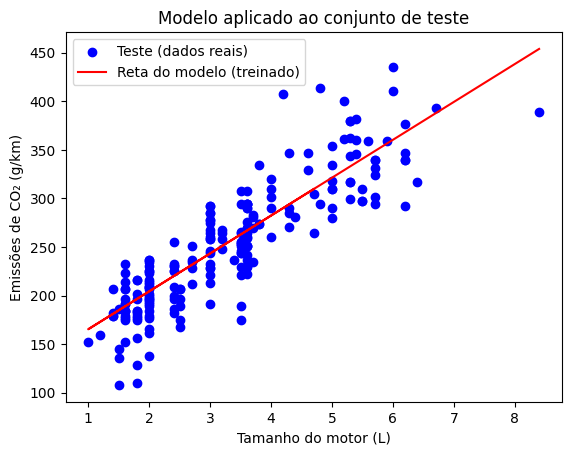

In [ ]:
plt.scatter(X_test, y_test, color='blue', label="Teste (dados reais)")
plt.plot(X_test, regressor.coef_[0]*X_test + regressor.intercept_, '-r', label="Reta do modelo (treinado)")
plt.xlabel("Tamanho do motor (L)")
plt.ylabel("Emissões de CO₂ (g/km)")
plt.title("Modelo aplicado ao conjunto de teste")
plt.legend()
plt.show()

#### [2] Use `FUELCONSUMPTION_COMB` como feature e divida os dados em 80%/20% (treino/teste).

Use o **mesmo `random_state`** de antes para comparar de forma justa com o resultado usando `ENGINESIZE`.

In [ ]:
X = cdf.FUELCONSUMPTION_COMB.to_numpy()
y = cdf.CO2EMISSIONS.to_numpy()  # aqui é opcional; mantido por consistência

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### [3] Treine um novo modelo linear com o conjunto de treino que você criou.


In [ ]:
# Novo modelo (agora usando FUELCONSUMPTION_COMB como feature)
regr = linear_model.LinearRegression()

# Ajuste no treino
regr.fit(X_train.reshape(-1, 1), y_train)

print("Coeficiente (b1):", regr.coef_[0])
print("Intercepto (b0):", regr.intercept_)

Coeficiente (b1): 16.180900781199195
Intercepto (b0): 69.10302617988444


#### [5] Use o novo modelo para prever no conjunto de teste (usando `FUELCONSUMPTION_COMB`).


In [ ]:
# Previsões no conjunto de teste com a nova feature (consumo combinado)
y_pred = regr.predict(X_test.reshape(-1, 1))

#### [5] Calcule e imprima o **MSE** das previsões no teste.


In [ ]:
print("MSE (erro quadrático médio): %.2f" % mean_squared_error(y_test, y_pred))

MSE (erro quadrático médio): 797.43


Em geral, o **MSE** fica menor quando treinamos com `FUELCONSUMPTION_COMB` do que com `ENGINESIZE` (porque o consumo combinado costuma ter relação mais direta com emissões).
